# Task 3 - Momentum Overlay

Load data needed for computations. 

In [139]:
# packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import Utils
from scipy.optimize import minimize 
import Backtest as bt   
import matplotlib.dates as mdates

In [140]:
# SET GLOBAL VALUES
mu_target = 75 / 10000 # Target
w_current = np.array([0,0.4, 0.6]) # current strategy
bond = pd.read_csv("Data_clean/bond_returns.csv")
stock = pd.read_csv("Data_clean/6_Portfolios_ME_Prior_12_2_returns.csv")
bond, stock =bond[["Date", "10YrReturns"]], stock[["Date", "Market Return"]]
stock["Market Return"] = stock["Market Return"] /100  
data = pd.merge(bond,stock, how='left', on = "Date")
RF = pd.read_csv("Data_clean/FF_cleaned.csv")
data = pd.merge(data.copy(),RF[["Date","RF"]], 'left',on = "Date" )
data["RF"] = data["RF"] /100 # assumed this must hold

MOMdep = pd.read_csv("Data_clean/25_Portfolios_ME_Prior_12_2_returns.csv")
MOMdep = MOMdep[["Date", "BIG LoPRIOR", "BIG HiPRIOR"]]
data = pd.merge(data.copy(),MOMdep, 'left',on = "Date" )
data["BIG LoPRIOR"], data["BIG HiPRIOR"] =data["BIG LoPRIOR"] /100, data["BIG HiPRIOR"] /100

In [141]:
data

,Date,10YrReturns,Market Return,RF,BIG LoPRIOR,BIG HiPRIOR
0,1990-01-31,-0.025702,-0.0724,0.0057,0.0009,-0.0942
1,1990-02-28,0.001547,0.0167,0.0057,0.0439,0.0113
2,1990-03-31,-0.002251,0.0246,0.0064,-0.0129,0.0334
3,1990-04-30,-0.017928,-0.0266,0.0069,-0.0619,-0.0179
4,1990-05-31,0.035839,0.0909,0.0068,0.1079,0.0999
...,...,...,...,...,...,...
403,2023-08-31,-0.006376,-0.0190,0.0045,-0.0899,0.0136
404,2023-09-30,-0.035790,-0.0480,0.0043,-0.0491,-0.0676
405,2023-10-31,-0.018635,-0.0261,0.0047,-0.0494,-0.0282
406,2023-11-30,0.044330,0.0930,0.0044,0.0784,0.1205


3.a 

In [142]:
# initial overlay
olay = 0.25
# The new Equity time-series:
data_ol = data.copy()
return_overlay = - olay * data["BIG LoPRIOR"] + olay * data["BIG HiPRIOR"]

data_ol["Market Return"] =  data_ol["Market Return"]+ return_overlay
data_ol = data_ol.drop(columns = ["BIG LoPRIOR", "BIG HiPRIOR"])


In [143]:
mu = np.mean([data_ol["RF"],data_ol["10YrReturns"],data_ol["Market Return"]],axis=1)
sigma = np.cov([data_ol["RF"],data_ol["10YrReturns"],data_ol["Market Return"]])
print("Mu", mu,"Sigma", sigma)

Mu [0.00213848 0.00432316 0.01020772] Sigma [[ 3.53053036e-06  4.63693106e-06 -3.58629318e-08]
 [ 4.63693106e-06  4.51987323e-04 -1.16761672e-05]
 [-3.58629318e-08 -1.16761672e-05  1.77650363e-03]]


Naive backtest:


C:\Users\andre\AppData\Local\Temp\ipykernel_25272\891183167.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


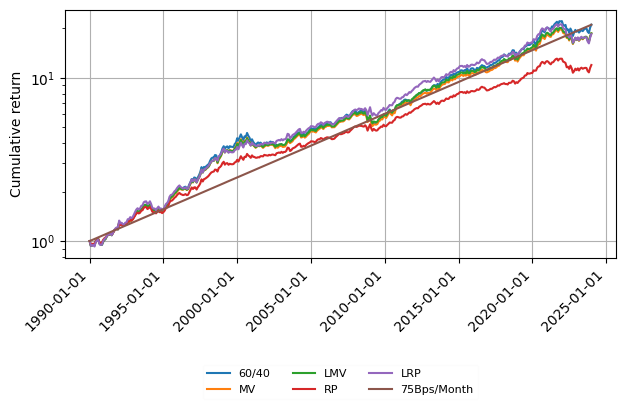

In [144]:
bt_naive, weights_naive,w1t,w2t  = bt.backtest_naive2(ind=data_ol, mu_target=mu_target) 
df_const = pd.DataFrame([[1,1,1,1,1,1,'1989-12-31']],columns=
                        bt_naive.columns)
bt_naive = pd.concat([df_const,bt_naive], ignore_index=True)
time = pd.date_range(bt_naive["Date"][0],bt_naive["Date"][len(bt_naive["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,bt_naive["R_40/60"], label="60/40")
ax.plot(time,bt_naive["R_MV"], label="MV")
ax.plot(time,bt_naive["R_MVL"], label="LMV")
ax.plot(time,bt_naive["R_RP"], label="RP")
ax.plot(time,bt_naive["R_RPL"], label="LRP")
ax.plot(time, [(mu_target+1)**(t) for t in range(0,len(time))],
         label = "75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.savefig("Figures/BT_task3_naive25_1990_2023",bbox_inches='tight')

plt.show()

In [145]:
[weights_naive[i].round(2) for i in range(0,len(weights_naive))]

[array([0. , 0.4, 0.6]),
 array([0.  , 0.46, 0.54]),
 array([-0.07,  0.56,  0.51]),
 array([0.  , 0.66, 0.34]),
 array([-0.29,  0.86,  0.43]),
 array([1., 0., 0.])]

In [146]:
# returns and std.
mus = [(weights_naive[i] @ mu).round(4) for i in range(0,len(weights_naive))]

std = [np.sqrt(weights_naive[i] @ sigma @ weights_naive[i]).round(4) for i in range(0,len(weights_naive))]
mus, std

([np.float64(0.0079),
  np.float64(0.0075),
  np.float64(0.0075),
  np.float64(0.0063),
  np.float64(0.0075),
  np.float64(0.0021)],
 [np.float64(0.0266),
  np.float64(0.0247),
  np.float64(0.0245),
  np.float64(0.0199),
  np.float64(0.0256),
  np.float64(0.0019)])

In [147]:
initial_fits = 12

test1, weights1,none, metrics = bt.backtest_k(ind=data_ol, mu_target=mu_target,m=initial_fits,l=1,K=1) 


C:\Users\andre\AppData\Local\Temp\ipykernel_25272\3909275627.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


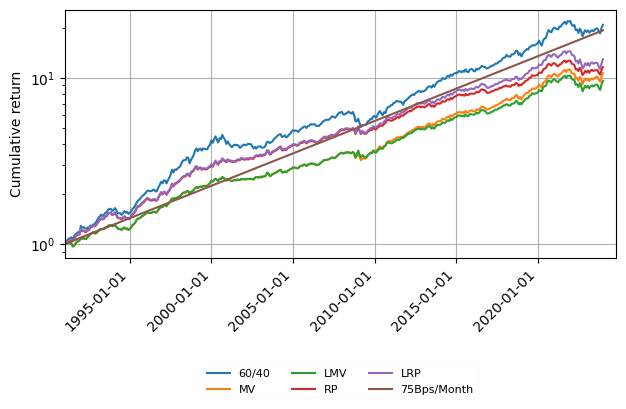

In [148]:
time = pd.date_range(test1["Date"][0],test1["Date"][len(test1["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test1["R_40/60"], label="60/40")
ax.plot(time,test1["R_MV"], label="MV")
ax.plot(time,test1["R_MVL"], label="LMV")
ax.plot(time,test1["R_RP"], label="RP")
ax.plot(time,test1["R_RPL"], label="LRP")
ax.plot(time[initial_fits-1:], [(mu_target+1)**(t+1) for t in range(-1,len(time)-initial_fits)],
         label = "75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
# Set scale (12 months of training)
plt.xlim((pd.Timestamp('1990-12-31'),pd.Timestamp.now())) 
# plt.title("Entire Period: 1990-2023")
plt.savefig("Figures/BT_task3_actual25_1990_2023",bbox_inches='tight')
plt.show()

It seems like the backtest is less volatile using the momentum overlay. Might be preferable but overall return would be lower. 

3.b Adding the cost. 

In [149]:
# The new Equity time-series:
data_ol_cost = data.copy()
return_overlay = - olay * data["BIG LoPRIOR"] + olay * data["BIG HiPRIOR"]
data_ol_cost["Market Return"] =  data_ol_cost["Market Return"]+ return_overlay
data_ol_cost["Market Return"] =  data_ol_cost["Market Return"] - Utils.manager_fee(return_overlay  )
mu_cost = np.mean([data_ol_cost["RF"],data_ol_cost["10YrReturns"],data_ol_cost["Market Return"]],axis=1)
sigma_cost = np.cov([data_ol_cost["RF"],data_ol_cost["10YrReturns"],data_ol_cost["Market Return"]])
print("Mu", mu_cost,"Sigma", sigma_cost)

Mu [0.00213848 0.00432316 0.00844721] Sigma [[ 3.53053036e-06  4.63693106e-06 -6.87057213e-08]
 [ 4.63693106e-06  4.51987323e-04 -1.42421990e-05]
 [-6.87057213e-08 -1.42421990e-05  1.77477079e-03]]


naive test  

C:\Users\andre\AppData\Local\Temp\ipykernel_25272\1466336611.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


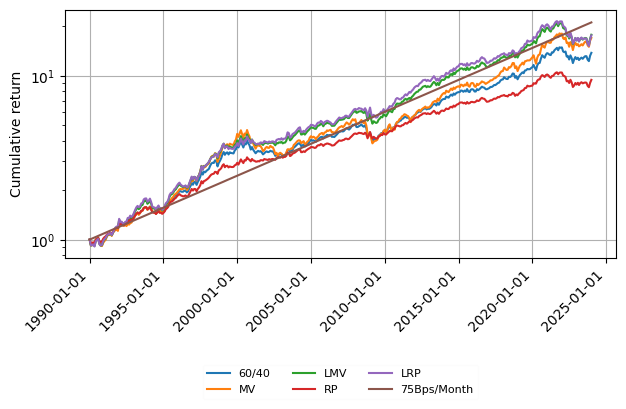

In [150]:
bt_naive2, weights_naive2,w1t,w2t  = bt.backtest_naive2(ind=data_ol_cost, mu_target=mu_target) 
df_const = pd.DataFrame([[1,1,1,1,1,1,'1989-12-31']],columns=
                        bt_naive2.columns)
bt_naive2 = pd.concat([df_const,bt_naive2], ignore_index=True)
time = pd.date_range(bt_naive2["Date"][0],bt_naive2["Date"][len(bt_naive2["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,bt_naive2["R_40/60"], label="60/40")
ax.plot(time,bt_naive2["R_MV"], label="MV")
ax.plot(time,bt_naive2["R_MVL"], label="LMV")
ax.plot(time,bt_naive2["R_RP"], label="RP")
ax.plot(time,bt_naive2["R_RPL"], label="LRP")
ax.plot(time, [(mu_target+1)**t for t in range(0,len(time))],
         label = "75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.savefig("Figures/BT_task3_naive25cost_1990_2023",bbox_inches='tight')
plt.show()

In [151]:
# Statistics
# returns and std

w_naive2_rounded = [weights_naive2[i].round(2) for i in range(0,len(weights_naive2))]
mus = [(weights_naive2[i] @ mu_cost).round(4) for i in range(0,len(weights_naive2))]

std = [np.sqrt(weights_naive2[i] @ sigma_cost @ weights_naive2[i]).round(4) for i in range(0,len(weights_naive2))]
print("weights",w_naive2_rounded)
print("means",mus)
print("standard deviations",std)


weights [array([0. , 0.4, 0.6]), array([-0.  ,  0.23,  0.77]), array([-0.37,  0.8 ,  0.57]), array([0.  , 0.66, 0.34]), array([-0.5,  1. ,  0.5]), array([1., 0., 0.])]
means [np.float64(0.0068), np.float64(0.0075), np.float64(0.0075), np.float64(0.0057), np.float64(0.0075), np.float64(0.0021)]
standard deviations [np.float64(0.0265), np.float64(0.0327), np.float64(0.0293), np.float64(0.0198), np.float64(0.0297), np.float64(0.0019)]


Normal Backtest

C:\Users\andre\AppData\Local\Temp\ipykernel_25272\2400874578.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


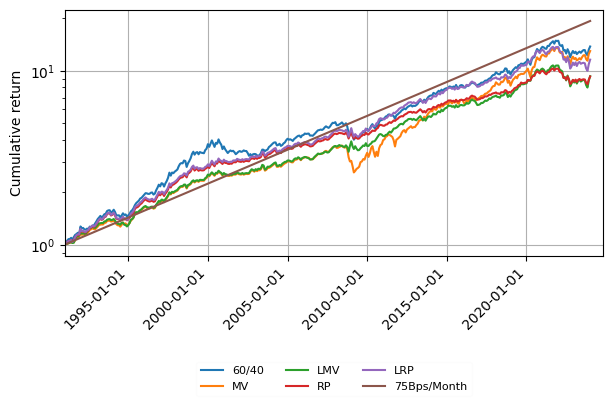

In [152]:
# Subtract cost in the backtest implementation. 
initial_fits = 12

test2, weights2,none, metrics = bt.backtest_k(ind=data_ol_cost, mu_target=mu_target,m=initial_fits,l=1,K=1) 
time = pd.date_range(test2["Date"][0],test2["Date"][len(test2["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test2["R_40/60"], label="60/40")
ax.plot(time,test2["R_MV"], label="MV")
ax.plot(time,test2["R_MVL"], label="LMV")
ax.plot(time,test2["R_RP"], label="RP")
ax.plot(time,test2["R_RPL"], label="LRP")
ax.plot(time[initial_fits-1:], [(mu_target+1)**(t+1) for t in range(-1,len(time)-initial_fits)],
         label = "75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.xlim((pd.Timestamp('1990-12-31'),pd.Timestamp.now()))

# plt.title("Entire Period: 1990-2023")
plt.savefig("Figures/BT_task3_actual25cost_1990_2023",bbox_inches='tight')

plt.show()

3.c b decreases performance. 

3.d

In [153]:
def olay_ret(olay, data):
    data_ol_cost = data.copy()
    # Find overlay returns
    return_overlay = - olay * data["BIG LoPRIOR"] + olay * data["BIG HiPRIOR"]
    # Find Equity return of overlay strat
    data_ol_cost["Market Return"] =  data_ol_cost["Market Return"] + return_overlay
    # Find return deducing costs
    data_ol_cost["Market Return"] =  data_ol_cost["Market Return"] - Utils.manager_fee(return_overlay  )

    data_ol_cost = data_ol_cost.drop(columns = ["BIG LoPRIOR", "BIG HiPRIOR"])

    cumret = (1+data_ol_cost["Market Return"]).cumprod()
    cumret = - cumret.iloc[-1]
    return cumret


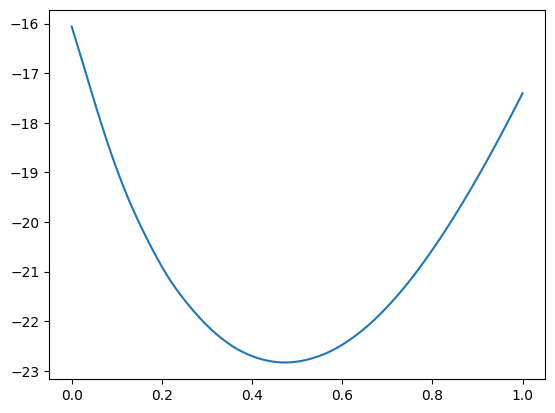

In [154]:
olay_list = [o*0.01 for o in range(0,101)]
olay_ret_list = [olay_ret(i, data) for i in olay_list]
olay_ret_list
plt.plot(olay_list, olay_ret_list)
plt.show()


In [155]:
res = minimize(fun = olay_ret, x0 = 0.1, method = 'trust-constr', 
                args =data, bounds = [(0,1)])
res.x
# Higher than what we can. As expected makes sense to go for as much leverage possible.

array([0.4733213])

In [156]:
# initial overlay
olay = res.x
# The new Equity time-series:
data_ol_cost = data.copy()
return_overlay = - olay * data["BIG LoPRIOR"] + olay * data["BIG HiPRIOR"]
# Find Equity return of overlay strat
data_ol_cost["Market Return"] =  data_ol_cost["Market Return"] + return_overlay
# Find return deducing costs
data_ol_cost["Market Return"] =  data_ol_cost["Market Return"] - Utils.manager_fee(return_overlay  )


data_ol_cost = data_ol_cost.drop(columns = ["BIG LoPRIOR", "BIG HiPRIOR"])
mu_cost = np.mean([data_ol_cost["RF"],data_ol_cost["10YrReturns"],data_ol_cost["Market Return"]],axis=1)
sigma_cost = np.cov([data_ol_cost["RF"],data_ol_cost["10YrReturns"],data_ol_cost["Market Return"]])

In [157]:
initial_fits = 12

test3, weights3,none, metrics = bt.backtest_k(ind=data_ol_cost, mu_target=mu_target,m=initial_fits,l=1,K=1) 

C:\Users\andre\AppData\Local\Temp\ipykernel_25272\3976627264.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


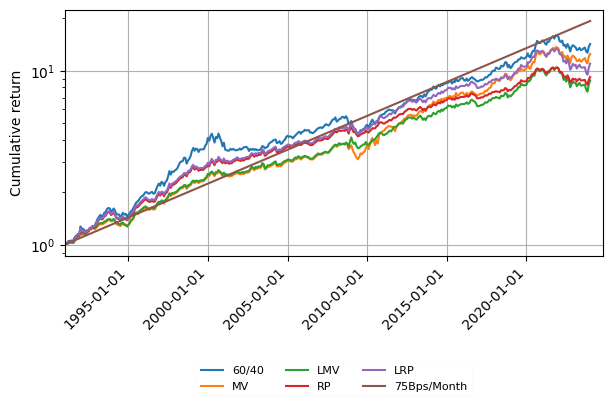

In [158]:
time = pd.date_range(test3["Date"][0],test3["Date"][len(test3["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,test3["R_40/60"], label="60/40")
ax.plot(time,test3["R_MV"], label="MV")
ax.plot(time,test3["R_MVL"], label="LMV")
ax.plot(time,test3["R_RP"], label="RP")
ax.plot(time,test3["R_RPL"], label="LRP")
ax.plot(time[initial_fits-1:], [(mu_target+1)**(t+1) for t in range(-1,len(time)-initial_fits)],
         label = "75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.xlim((pd.Timestamp('1990-12-31'),pd.Timestamp.now()))

plt.savefig("Figures/BT_task3_actualoptcost_1990_2023",bbox_inches='tight')

plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_25272\1971807290.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


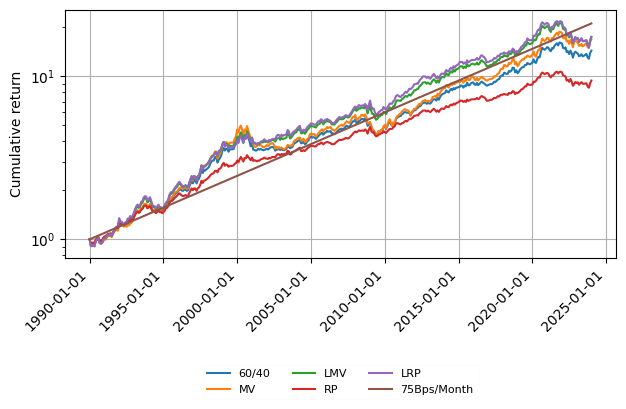

In [159]:
bt_naive3, weights_naive3,w1t,w2t  = bt.backtest_naive2(ind=data_ol_cost, mu_target=mu_target) 
df_const = pd.DataFrame([[1,1,1,1,1,1,'1989-12-31']],columns=
                        bt_naive3.columns)
bt_naive3 = pd.concat([df_const,bt_naive3], ignore_index=True)
time = pd.date_range(bt_naive3["Date"][0],bt_naive3["Date"][len(bt_naive3["Date"]) -1 ], freq = 'ME')
fig, ax = plt.subplots(layout='constrained')
ax.plot(time,bt_naive3["R_40/60"], label="60/40")
ax.plot(time,bt_naive3["R_MV"], label="MV")
ax.plot(time,bt_naive3["R_MVL"], label="LMV")
ax.plot(time,bt_naive3["R_RP"], label="RP")
ax.plot(time,bt_naive3["R_RPL"], label="LRP")
ax.plot(time, [(mu_target+1)**t for t in range(0,len(time))],
         label = "75Bps/Month")

ax.xaxis.set_major_locator(mdates.YearLocator(5))  # Set a tick at the start of every year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.legend(framealpha=0.05,loc='center', bbox_to_anchor=(0.5, -0.5), ncol=3,prop={'size': 8})
plt.tight_layout()

plt.grid()
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("Cumulative return")
plt.savefig("Figures/BT_task3_naiveoptcost_1990_2023",bbox_inches='tight')
plt.show()

In [160]:
w_naive3_rounded = [weights_naive3[i].round(3) for i in range(0,len(weights_naive3))]
mus = [(weights_naive3[i] @ mu_cost).round(4) for i in range(0,len(weights_naive3))]

std = [np.sqrt(weights_naive3[i] @ sigma_cost @ weights_naive3[i]).round(4) for i in range(0,len(weights_naive3))]
print("weights",w_naive3_rounded)
print("means",mus)
print("standard deviations",std)


weights [array([0. , 0.4, 0.6]), array([-0.  ,  0.28,  0.72]), array([-0.358,  0.815,  0.543]), array([0.   , 0.682, 0.318]), array([-0.494,  1.018,  0.476]), array([1., 0., 0.])]
means [np.float64(0.007), np.float64(0.0075), np.float64(0.0075), np.float64(0.0057), np.float64(0.0075), np.float64(0.0021)]
standard deviations [np.float64(0.0289), np.float64(0.0335), np.float64(0.0306), np.float64(0.0208), np.float64(0.031), np.float64(0.0019)]
